### Imporing Libaraies

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import joblib

### Reading Data

In [ ]:
# Reading Data
dt = pd.read_csv(r"Data\Data_Parameters.csv", low_memory=False)

# Dropping unnecessary columns
dt.drop(columns=['comments', 'sensor_cleaning'], inplace=True)

# Printing summary of data
print(round(dt.describe(), 2))

### Checking for missing values and filling them

In [ ]:
# Checking for missing values
print(dt.isnull().sum())

### Visulaizing Data Using Corealtion Matrix

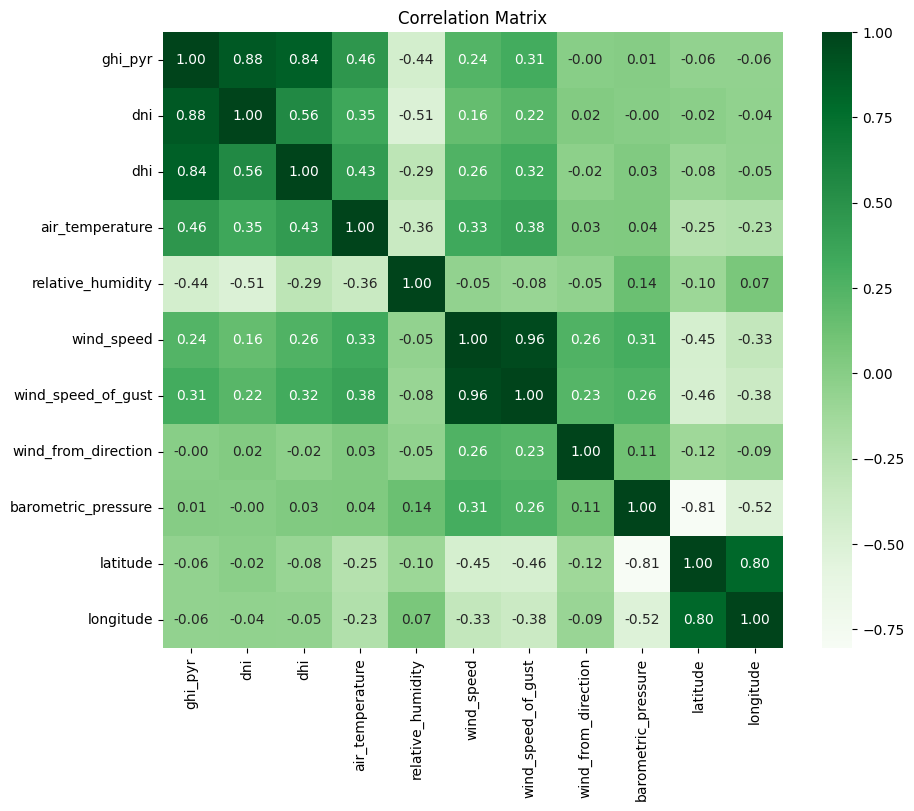

In [5]:
# Visualizing Data Using Correlation Matrix
columns_of_interest = [
    'ghi_pyr', 'dni', 'dhi', 'air_temperature', 'relative_humidity',
    'wind_speed', 'wind_speed_of_gust', 'wind_from_direction', 'barometric_pressure',
    'latitude', 'longitude'
]
corr_data = dt[columns_of_interest]

# Calculating the correlation matrix
corr_matrix = corr_data.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Greens", cbar=True)
plt.title("Correlation Matrix")
plt.show()

### Feature Engineering (extract time features and add latitude/longitude)

/var/folders/yk/4x0rwrpd4wq646zmkt3fcpc80000gn/T/ipykernel_67872/903753953.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dt['hour'] = pd.to_datetime(dt['time']).dt.hour
/var/folders/yk/4x0rwrpd4wq646zmkt3fcpc80000gn/T/ipykernel_67872/903753953.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dt['day_of_week'] = pd.to_datetime(dt['time']).dt.dayofweek
/var/folders/yk/4x0rwrpd4wq646zmkt3fcpc80000gn/T/ipykernel_67872/903753953.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dt['month'] = pd.to_datetime(dt['time']).dt.month


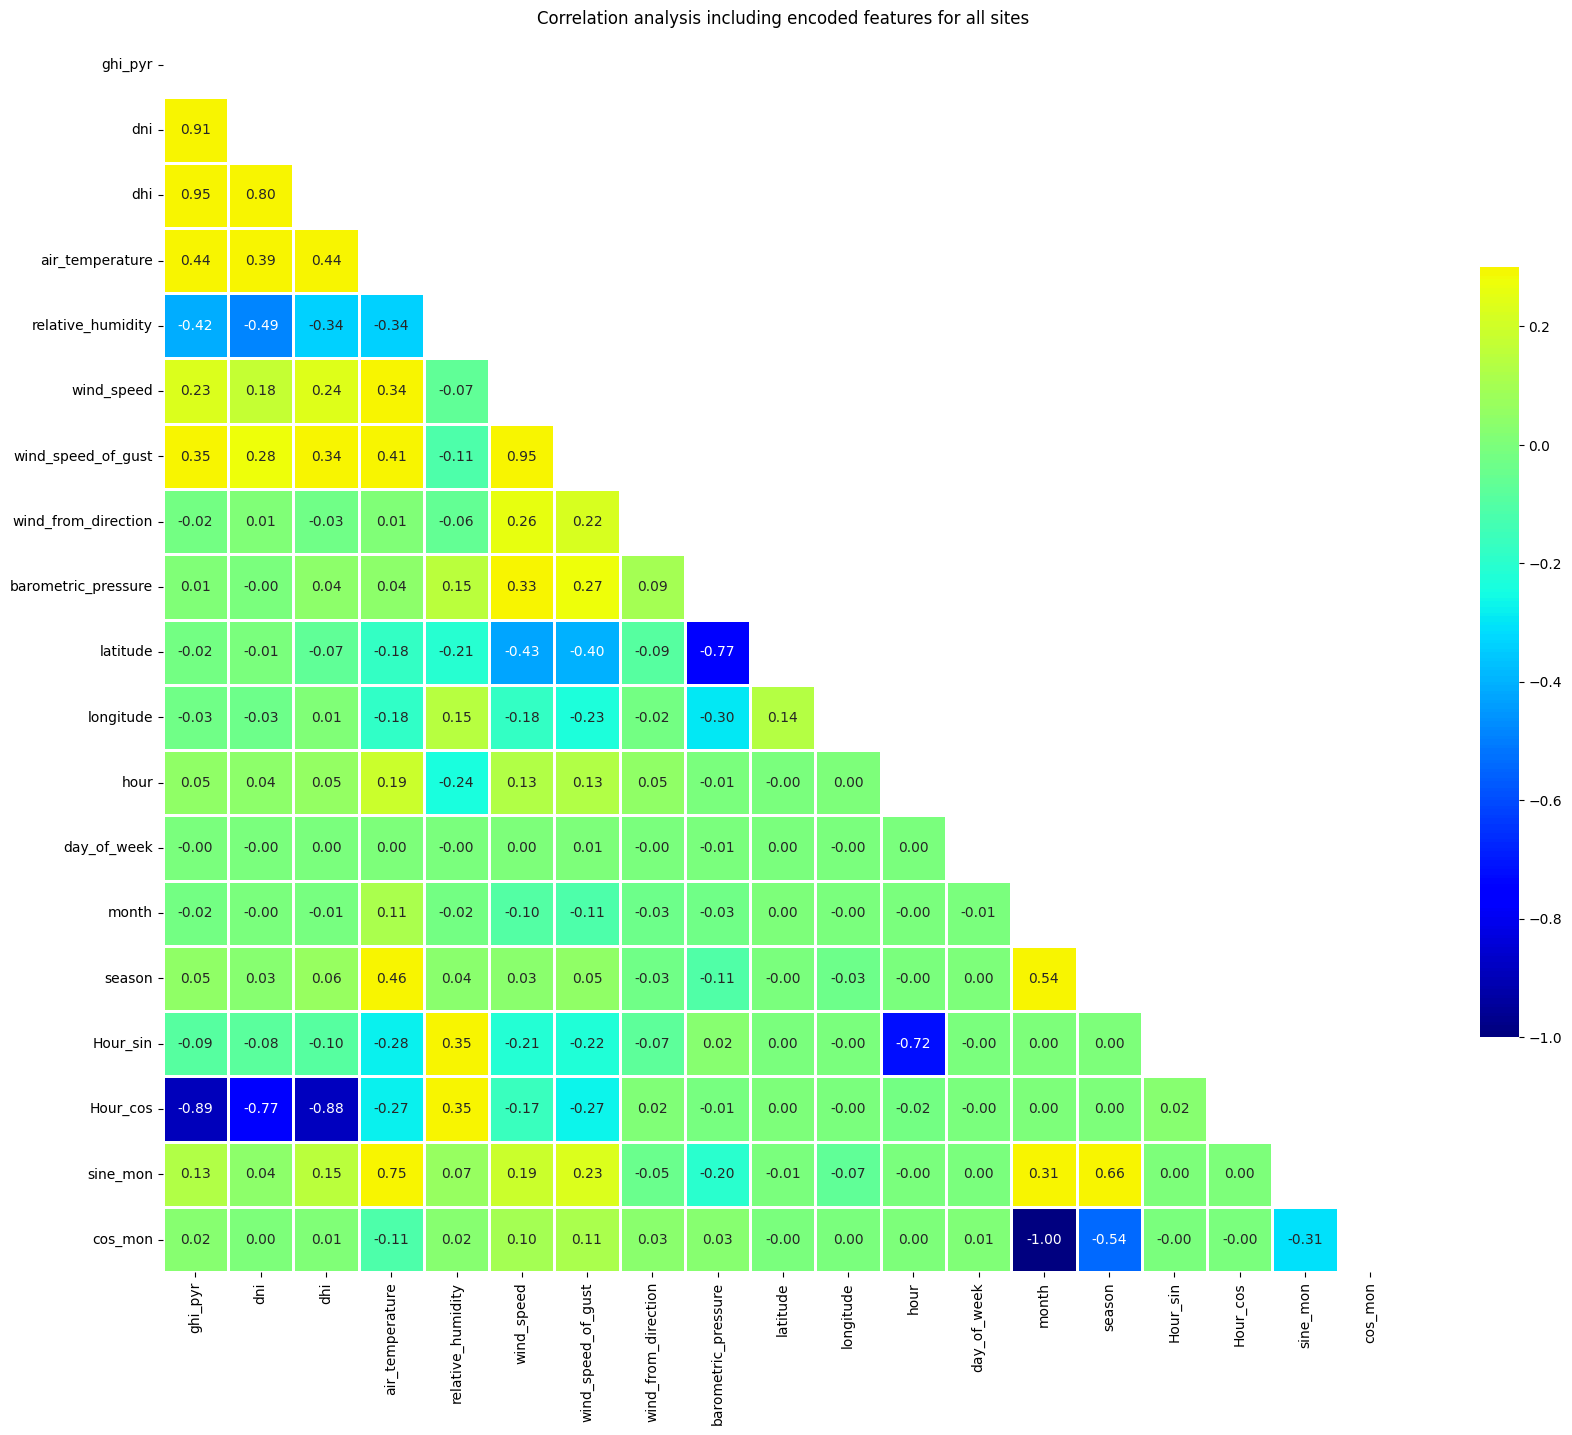

In [6]:
# Feature Engineering: Extracting time features and adding latitude/longitude
dt['hour'] = pd.to_datetime(dt['time']).dt.hour
dt['day_of_week'] = pd.to_datetime(dt['time']).dt.dayofweek
dt['month'] = pd.to_datetime(dt['time']).dt.month
dt['season'] = dt['month'].apply(lambda x: (x % 12 + 3) // 3)  # Quarter of the year

# Creating cyclic features for 'hour' and 'month'
max_hour_value = dt['hour'].max()
dt['Hour_sin'] = np.sin(2 * np.pi * dt['hour'] / max_hour_value)
dt['Hour_cos'] = np.cos(2 * np.pi * dt['hour'] / max_hour_value)

dt['sine_mon'] = np.sin((dt['month'] - 1) * np.pi / 12)
dt['cos_mon'] = np.cos((dt['month'] - 1) * np.pi / 12)

# Save the updated DataFrame with new features to a CSV file
dt.to_csv(r'Data\Data_Parameters_new_features.csv', index=False)

# Correlation analysis with additional features
columns_of_interest = [
    'ghi_pyr', 'dni', 'dhi', 'air_temperature', 'relative_humidity',
    'wind_speed', 'wind_speed_of_gust', 'wind_from_direction', 'barometric_pressure',
    'latitude', 'longitude', 'hour', 'day_of_week', 'month', 'season', 'Hour_sin', 'Hour_cos', 'sine_mon', 'cos_mon'
]

# Plot correlation heatmap using Spearman method
mask2 = np.triu(np.ones_like(dt[columns_of_interest].corr(), dtype=bool))

f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(dt[columns_of_interest].corr(method='spearman'), mask=mask2, cmap='jet', vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.9, cbar_kws={"shrink": .5})
plt.title('Correlation analysis including encoded features for all sites')
plt.show()


### Visualize missing values

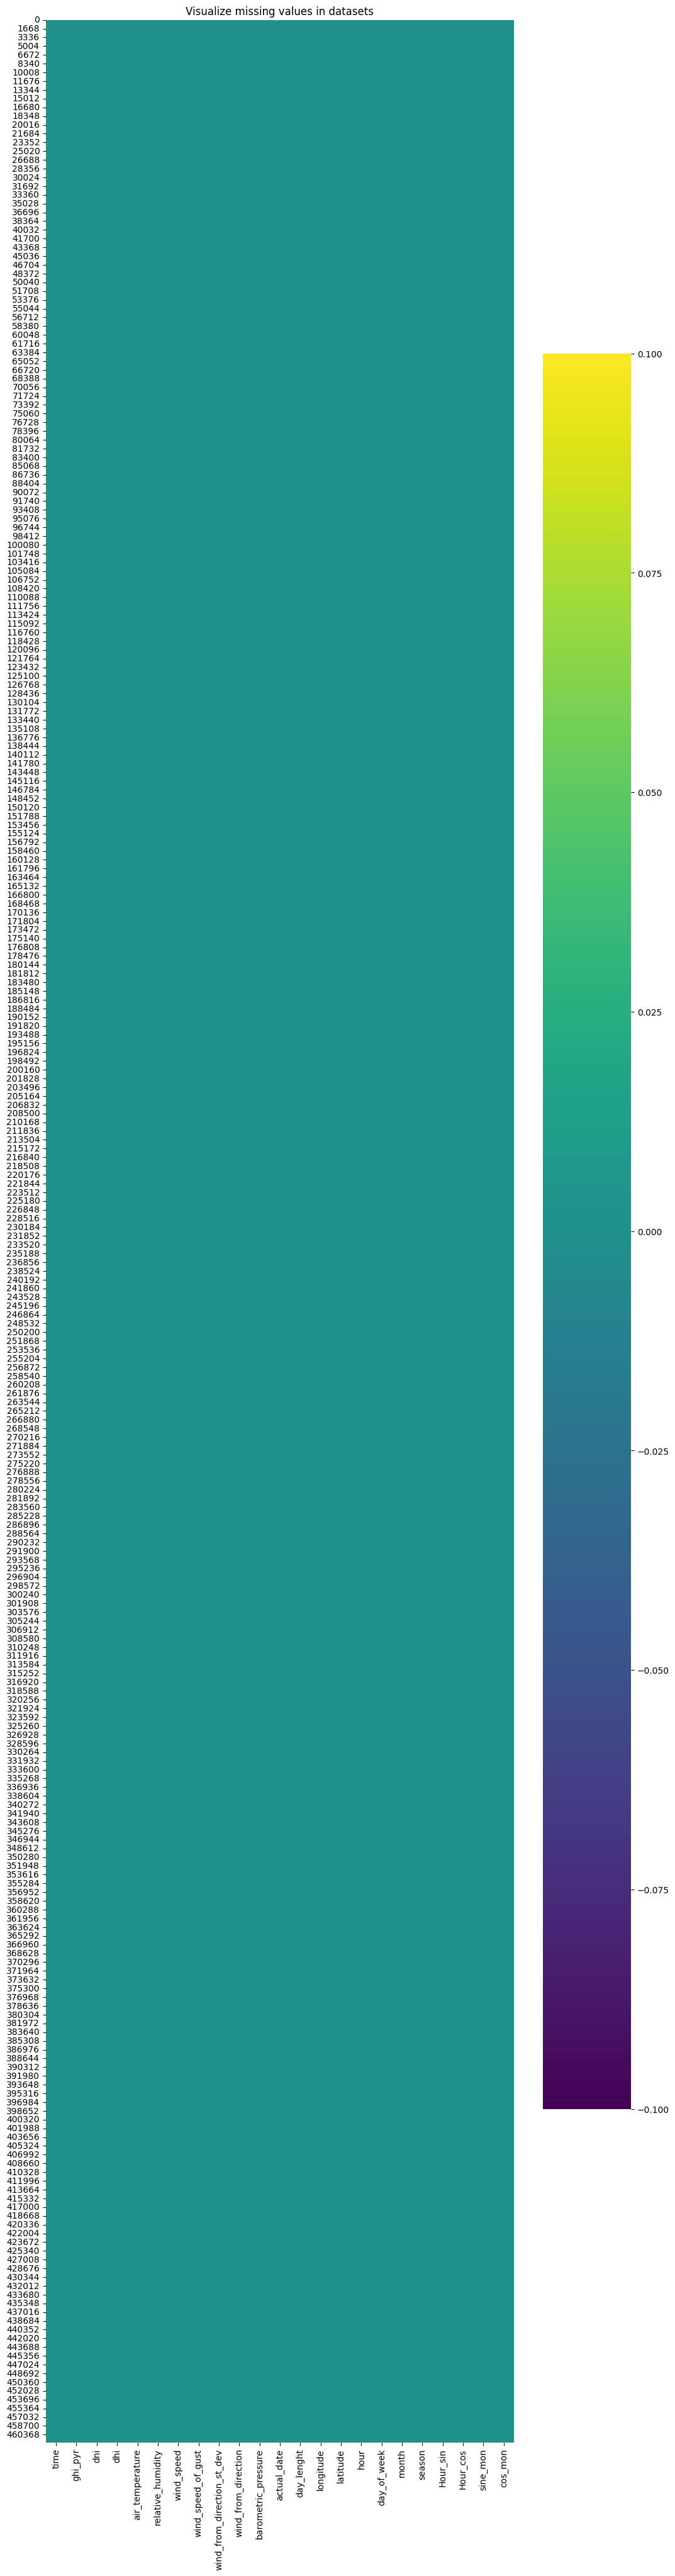

In [7]:
# Visualize missing values
plt.figure(figsize=(12, 50))
sns.heatmap(dt.isnull(), cmap='viridis')
plt.title('Visualize missing values in datasets')
plt.show()

### Using model

In [8]:

# Feature and target columns
# columns_of_interest_x = [
#     'latitude', 'longitude', 'hour', 'day_of_week', 
#     'month', 'season', 'Hour_sin', 'Hour_cos', 'sine_mon', 'cos_mon'
# ]
columns_of_interest_x = [
    'latitude', 'longitude', 'hour', 'day_of_week', 
    'month', 'season',
]

columns_of_interest_y = [
    'ghi_pyr', 'dni', 'dhi', 'air_temperature', 'relative_humidity',
    'wind_speed', 'wind_speed_of_gust', 'wind_from_direction', 'barometric_pressure',
]

# Splitting into features and target
X = dt[columns_of_interest_x]
y = dt[columns_of_interest_y]



In [9]:
# Checking the information of the data
X.info()
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461849 entries, 0 to 461848
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   latitude     461849 non-null  float64
 1   longitude    461849 non-null  float64
 2   hour         461849 non-null  int32  
 3   day_of_week  461849 non-null  int32  
 4   month        461849 non-null  int32  
 5   season       461849 non-null  int64  
dtypes: float64(2), int32(3), int64(1)
memory usage: 15.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461849 entries, 0 to 461848
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ghi_pyr              461849 non-null  float64
 1   dni                  461849 non-null  float64
 2   dhi                  461849 non-null  float64
 3   air_temperature      461849 non-null  float64
 4   relative_humidity    461849 non-null  float64
 5   wind_speed   

In [10]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [11]:
# Creating base LightGBM model
lgbm_base = lgb.LGBMRegressor()

# Wrapping LightGBM model in MultiOutputRegressor
multi_target_model = MultiOutputRegressor(lgbm_base)

#### Perform Cross-Validation on training data for hyper parameter tuning

In [12]:
# Hyperparameter grid for RandomizedSearchCV
param_dist = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__learning_rate': [0.01, 0.05, 0.1],
    'estimator__num_leaves': [31, 50, 70],
    'estimator__max_depth': [-1, 5, 10],
    'estimator__feature_fraction': [0.6, 0.8, 1.0]
}

# Set up RandomizedSearchCV
lgbm_random = RandomizedSearchCV(
    estimator=multi_target_model,
    param_distributions=param_dist,
    n_iter=10,  # Number of random samples
    scoring='neg_mean_squared_error',  # Choose appropriate metric
    cv=5,  # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

#### Random Search Cv

In [13]:
%%time
# Fit the RandomizedSearchCV model
lgbm_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 

RandomizedSearchCV(cv=5,
                   estimator=MultiOutputRegressor(estimator=LGBMRegressor()),
                   n_jobs=-1,
                   param_distributions={'estimator__feature_fraction': [0.6,
                                                                        0.8,
                                                                        1.0],
                                        'estimator__learning_rate': [0.01, 0.05,
                                                                     0.1],
                                        'estimator__max_depth': [-1, 5, 10],
                                        'estimator__n_estimators': [50, 100,
                                                                    200],
                                        'estimator__num_leaves': [31, 50, 70]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [14]:
# Best Hyperparameters after Random Search
print(f"Best Hyperparameters: {lgbm_random.best_params_}")

Best Hyperparameters: {'estimator__num_leaves': 70, 'estimator__n_estimators': 200, 'estimator__max_depth': 10, 'estimator__learning_rate': 0.05, 'estimator__feature_fraction': 1.0}


In [15]:
# Predictions on the test set
y_pred = lgbm_random.predict(X_test)

# Evaluate the model performance for each target variable
for idx, target in enumerate(columns_of_interest_y):
    print(f"\nEvaluating {target}:")
    print(f"R2 Score: {r2_score(y_test.iloc[:, idx], y_pred[:, idx])}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test.iloc[:, idx], y_pred[:, idx])}")
    print(f"Mean Squared Error: {mean_squared_error(y_test.iloc[:, idx], y_pred[:, idx])}")
    print(f"Explained Variance Score: {explained_variance_score(y_test.iloc[:, idx], y_pred[:, idx])}")
    print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test.iloc[:, idx], y_pred[:, idx]))}\n")

# Save the trained model
joblib.dump(lgbm_random.best_estimator_, "EM Project\Saved_Models\saved_model_parameters.pkl")

# Predictions on the full dataset
y_all_pred = lgbm_random.predict(X)


# # Save predictions to a CSV file
# results = pd.DataFrame(y_all_pred, columns=columns_of_interest_y)
# results.to_csv("predictions_on_full_dataset.csv", index=False)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGB

In [ ]:
# Optional: Save evaluation metrics
cv_results_df = pd.DataFrame(lgbm_random.cv_results_)
cv_results_df.to_csv("cv_results_lgbm_random.csv", index=False)

print("Cross-validation results have been saved to 'cv_results_lgbm_random.csv'.")